#Locally adaptive Bayesian covariance regression:
## Algorithm test

Here, we follow the algorithm given in [Durante, Scarpa, and Dunson (2014)](https://www.researchgate.net/profile/David_Dunson/publication/232063211_Locally_adaptive_factor_processes_for_multivariate_time_series/links/09e4150df41e8d582a000000.pdf). In particular, we are following Appendix A.2.

In [1]:
# set random seed
srand(12345);

# Load data

In [2]:
using HDF5

fid = h5open("data/labcr_test_data.jld", "r")

vars_to_read = [:y, :theta, :xi, :psi]

for v in vars_to_read
    expr = :($v = read(fid[$("/$v")]))
    eval(expr)
end
close(fid)

In [3]:
using PyPlot
plt.style[:use]("ggplot")

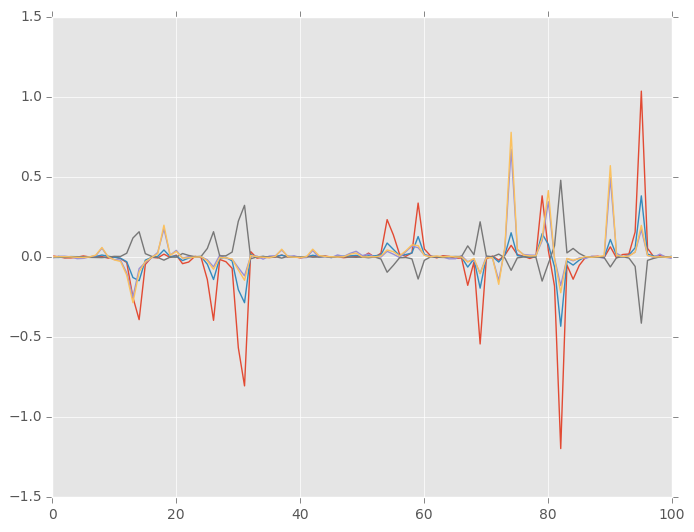

5-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x323cda7d0>
 PyObject <matplotlib.lines.Line2D object at 0x323cdaa50>
 PyObject <matplotlib.lines.Line2D object at 0x323cdac90>
 PyObject <matplotlib.lines.Line2D object at 0x323cdae50>
 PyObject <matplotlib.lines.Line2D object at 0x323ce9050>

In [4]:
plot(y)